In [2]:
from pickle import load
from numpy import argmax
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras.models import load_model
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.python.keras.applications import VGG16
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
import keras
from keras.utils import CustomObjectScope
from keras.initializers import glorot_uniform
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
from PIL import Image

import sys


In [3]:
image_model = VGG16(include_top=True, weights='imagenet')

In [4]:
transfer_layer = image_model.get_layer('fc2')

In [5]:
image_model_transfer = Model(inputs=image_model.input,
                             outputs=transfer_layer.output)

In [6]:
img_size = K.int_shape(image_model.input)[1:3]

In [7]:
transfer_values_size = K.int_shape(transfer_layer.output)[1]

In [8]:
mark_start = 'ssss '
mark_end = ' eeee'

In [9]:
def mark_captions(captions_listlist):
    captions_marked = [[mark_start + caption + mark_end
                        for caption in captions_list]
                        for captions_list in captions_listlist]
    
    return captions_marked

In [10]:
def flatten(captions_listlist):
    captions_list = [caption
                     for captions_list in captions_listlist
                     for caption in captions_list]
    
    return captions_list

In [11]:
num_words = 10000

In [12]:
class TokenizerWrap(Tokenizer):
    """Wrap the Tokenizer-class from Keras with more functionality."""
    
    def __init__(self, texts, num_words=None):
        """
        :param texts: List of strings with the data-set.
        :param num_words: Max number of words to use.
        """

        Tokenizer.__init__(self, num_words=num_words)

        # Create the vocabulary from the texts.
        self.fit_on_texts(texts)

        # Create inverse lookup from integer-tokens to words.
        self.index_to_word = dict(zip(self.word_index.values(),
                                      self.word_index.keys()))

    def token_to_word(self, token):
        """Lookup a single word from an integer-token."""

        word = " " if token == 0 else self.index_to_word[token]
        return word 

    def tokens_to_string(self, tokens):
        """Convert a list of integer-tokens to a string."""

        # Create a list of the individual words.
        words = [self.index_to_word[token]
                 for token in tokens
                 if token != 0]
        
        # Concatenate the words to a single string
        # with space between all the words.
        text = " ".join(words)

        return text
    
    def captions_to_tokens(self, captions_listlist):
        """
        Convert a list-of-list with text-captions to
        a list-of-list of integer-tokens.
        """
        
        # Note that text_to_sequences() takes a list of texts.
        tokens = [self.texts_to_sequences(captions_list)
                  for captions_list in captions_listlist]
        
        return tokens

In [13]:
# token_start = tokenizer.word_index[mark_start.strip()]

In [14]:
# token_end = tokenizer.word_index[mark_end.strip()]

In [15]:
num_words = 10000

In [16]:
def sparse_cross_entropy(y_true, y_pred):
    """
    Calculate the cross-entropy loss between y_true and y_pred.
    
    y_true is a 2-rank tensor with the desired output.
    The shape is [batch_size, sequence_length] and it
    contains sequences of integer-tokens.

    y_pred is the decoder's output which is a 3-rank tensor
    with shape [batch_size, sequence_length, num_words]
    so that for each sequence in the batch there is a one-hot
    encoded array of length num_words.
    """

    # Calculate the loss. This outputs a
#     # 2-rank tensor of shape [batch_size, sequence_length]
#     loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true,
#                                                           logits=y_pred)
    loss=tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
            logits=y_pred,labels=tf.argmax(y_true,1)))

    # Keras may reduce this across the first axis (the batch)
    # but the semantics are unclear, so to be sure we use
    # the loss across the entire 2-rank tensor, we reduce it
    # to a single scalar with the mean function.
    loss_mean = tf.reduce_mean(loss)

    return loss_mean

In [17]:
# load the tokenizer
tokenizer = load(open('tokenizer.pkl', 'rb'))

In [18]:
optimizer = RMSprop(lr=1e-3)

In [19]:
with CustomObjectScope({'GlorotUniform': glorot_uniform()}):
     model = load_model('ModelCaption2.h5',custom_objects={ 'sparse_cross_entropy': sparse_cross_entropy})

In [20]:
decoder_model =model

In [21]:
# decoder_model.summary()

In [31]:
def load_image(path, size=None):
    """
    Load the image from the given file-path and resize it
    to the given size if not None.
    """

    # Load the image using PIL.
    img = Image.open(path)

    # Resize image if desired.
    if not size is None:
        img = img.resize(size=size, resample=Image.LANCZOS)

    # Convert image to numpy array.
    img = np.asarray(img)

    # Scale image-pixels so they fall between 0.0 and 1.0
    img = img / float(255.0)

#     img = img.reshape(224,224,3)
    
#     print (img.shape)
#     print (len(img.shape))

    # Convert 2-dim gray-scale array to 3-dim RGB array.
    if (len(img.shape) == 2):
        img = np.repeat(img[:, :, np.newaxis], 3, axis=2)
         
    return img

In [32]:
load_image("plane.jpg")

array([[[0.50196078, 0.61960784, 0.72941176],
        [0.48627451, 0.60392157, 0.71372549],
        [0.4627451 , 0.58431373, 0.69803922],
        ...,
        [0.24705882, 0.42745098, 0.62352941],
        [0.24705882, 0.42745098, 0.62352941],
        [0.24705882, 0.42745098, 0.62352941]],

       [[0.56470588, 0.6745098 , 0.76862745],
        [0.55294118, 0.6627451 , 0.75686275],
        [0.53333333, 0.63921569, 0.74509804],
        ...,
        [0.24705882, 0.42745098, 0.62352941],
        [0.24705882, 0.42745098, 0.62352941],
        [0.24705882, 0.42745098, 0.62352941]],

       [[0.65098039, 0.7372549 , 0.81960784],
        [0.64705882, 0.73333333, 0.81568627],
        [0.62745098, 0.7254902 , 0.81176471],
        ...,
        [0.25098039, 0.43137255, 0.62745098],
        [0.25098039, 0.43137255, 0.62745098],
        [0.25098039, 0.43137255, 0.62745098]],

       ...,

       [[0.91372549, 0.90980392, 0.90196078],
        [0.90980392, 0.90980392, 0.90980392],
        [0.90196078, 0

In [52]:
def generate_caption(image_path, max_tokens=30):
    """
    Generate a caption for the image in the given path.
    The caption is limited to the given number of tokens (words).
    """

    # Load and resize the image.
    image = load_image(image_path, size=img_size)
    
    # Expand the 3-dim numpy array to 4-dim
    # because the image-model expects a whole batch as input,
    # so we give it a batch with just one image.
    image_batch = np.expand_dims(image, axis=0)

    # Process the image with the pre-trained image-model
    # to get the transfer-values.
    transfer_values = image_model_transfer.predict(image_batch)

    # Pre-allocate the 2-dim array used as input to the decoder.
    # This holds just a single sequence of integer-tokens,
    # but the decoder-model expects a batch of sequences.
    shape = (1, max_tokens)
    decoder_input_data = np.zeros(shape=shape, dtype=np.int)

    # The first input-token is the special start-token for 'ssss '.
    token_int = token_start

    # Initialize an empty output-text.
    output_text = ''

    # Initialize the number of tokens we have processed.
    count_tokens = 0

    # While we haven't sampled the special end-token for ' eeee'
    # and we haven't processed the max number of tokens.
    while token_int != token_end and count_tokens < max_tokens:
        # Update the input-sequence to the decoder
        # with the last token that was sampled.
        # In the first iteration this will set the
        # first element to the start-token.
        decoder_input_data[0, count_tokens] = token_int

        # Wrap the input-data in a dict for clarity and safety,
        # so we are sure we input the data in the right order.
        x_data = \
        {
            'transfer_values_input': transfer_values,
            'decoder_input': decoder_input_data
        }

        # Note that we input the entire sequence of tokens
        # to the decoder. This wastes a lot of computation
        # because we are only interested in the last input
        # and output. We could modify the code to return
        # the GRU-states when calling predict() and then
        # feeding these GRU-states as well the next time
        # we call predict(), but it would make the code
        # much more complicated.
        
        # Input this data to the decoder and get the predicted output.
        decoder_output = decoder_model.predict(x_data)

        # Get the last predicted token as a one-hot encoded array.
        # Note that this is not limited by softmax, but we just
        # need the index of the largest element so it doesn't matter.
        token_onehot = decoder_output[0, count_tokens, :]

        # Convert to an integer-token.
        token_int = np.argmax(token_onehot)

        # Lookup the word corresponding to this integer-token.
        sampled_word = tokenizer.token_to_word(token_int)

        # Append the word to the output-text.
        output_text += " " + sampled_word

        # Increment the token-counter.
        count_tokens += 1

    # This is the sequence of tokens output by the decoder.
    output_tokens = decoder_input_data[0]

    # Plot the image.
    plt.imshow(image)
    plt.show 
#     Print the predicted caption.
    print("Predicted caption:")
    output=output_text
#     print(output)
    return output
#     return output_text
#     print()

In [53]:
# decoder_target = tf.placeholder(dtype='int32', shape=(None, None))

In [54]:
token_start = tokenizer.word_index[mark_start.strip()]

In [55]:
token_end = tokenizer.word_index[mark_end.strip()]

Predicted caption:


' a man in a suit and tie with a smile on his face eeee'

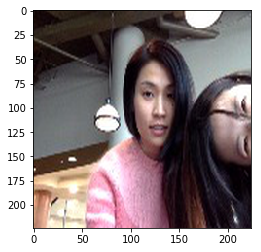

In [56]:
generate_caption("../Tester/selfie2222.jpg")

Predicted caption:


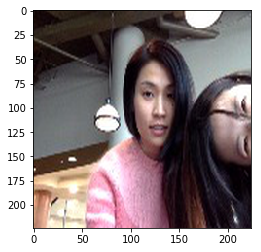

In [57]:
test = generate_caption("../Tester/selfie2222.jpg")

In [58]:
test

' a man in a suit and tie with a smile on his face eeee'

In [38]:
pwd

'/Users/chenchen/Downloads/HW/Image-Caption-App/Image-Caption-App'